# 0.0 Imports

In [1]:
# Basic Tools
import pandas    as pd
import numpy     as np
import seaborn   as sns
%matplotlib inline
from matplotlib import pyplot as plt
from watermark  import watermark
import plotly


# Model Evalutation Tools
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_predict 
from sklearn.preprocessing   import RobustScaler, MinMaxScaler

# HyperTunning Tools
import optuna

# Modelos de Machine Learning
from lightgbm         import LGBMClassifier
from xgboost          import XGBClassifier
from sklearn.ensemble import RandomForestClassifier , VotingClassifier



# Model Evaluation Tools
from sklearn.metrics import f1_score , precision_score ,  confusion_matrix , ConfusionMatrixDisplay , classification_report


# feature importance tools
import shap
from shap import plots

RANDOM_SEED  = 42

## 0.1 Configurações

In [2]:
# Mostra as informações do sistema 
print(watermark())

Last updated: 2023-08-26T11:05:50.021897+01:00

Python implementation: CPython
Python version       : 3.9.17
IPython version      : 8.13.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
# Mostra as versões dos pacotes
print( watermark( packages = 'pandas,numpy,seaborn,matplotlib,watermark,scikit-learn,plotly,lightgbm,optuna,xgboost' ) )

pandas      : 2.0.3
numpy       : 1.23.5
seaborn     : 0.12.2
matplotlib  : 3.7.2
watermark   : 2.4.3
scikit-learn: 1.3.0
plotly      : 5.16.1
lightgbm    : 4.0.0
optuna      : 3.3.0
xgboost     : 1.7.6



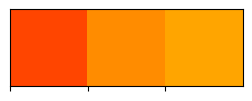

In [4]:
# Configurações da paleta de cores
layout_palette = ['#FF4500','#FF8C00','#FFA500']
sns.set_palette( layout_palette )

cm = sns.light_palette( '#F0FFFF' ) # criar paleta de cores claras

#plota uma preview das paletas de cores
sns.palplot( sns.color_palette( layout_palette ) )

In [5]:
# configura as opções de visualizações de colunas e linhas no df
pd.set_option( 'display.max_columns', 30 )
pd.set_option( 'display.max_rows', 25)

# 1 - Loading Data

In [6]:
data_train_raw = pd.read_csv( 'data/train.csv' )
data_test_raw  = pd.read_csv( 'data/test.csv' )

In [7]:
# ver a dimensão dos dados
data_train_raw.shape , data_test_raw.shape

((103904, 24), (25976, 23))

# 2 - Data Processing

In [8]:
df = data_train_raw.copy()
teste = data_test_raw.copy()

In [9]:
# função para preencher os NaN's
def PREPROCESSING( df, verbose = True ):
    
    if verbose == True:
        print( 'NaN Antes: ' , df.isna().sum().sum() )
        
        df['Delivery delay in minutes'] = df['Delivery delay in minutes'].fillna( df['Carrier delay in minutes'] )
        
        print( 'NaN Depois: ', df.isna().sum().sum() )
        
        
    return df

In [10]:
# aplicando as alterações na base de treino
df = PREPROCESSING( df )

NaN Antes:  310
NaN Depois:  0


In [11]:
# aplicando as alterações na base de teste
teste = PREPROCESSING( teste )

NaN Antes:  83
NaN Depois:  0


# 3 - Exploratory Data Analysis

In [12]:
df_eda = df.copy()

In [13]:
# função para as métricas estatísticas
def summary_stats( df ):
    # inclui somente números no df
    numerical_features = df.select_dtypes( include = ['number'] ).columns.values
    df = df[ numerical_features ]
    
    # calcula as métricas
    count_  = pd.DataFrame( df.apply(np.size) )
    sum_    = pd.DataFrame( df.apply(np.sum) )
    mean_   = pd.DataFrame( df.apply(np.mean))
    std_    = pd.DataFrame( df.apply(np.std) )
    median_ = pd.DataFrame( df.apply(np.median))
    
    min_    = pd.DataFrame( df.apply(min))
    max_    = pd.DataFrame( df.apply(max))
    range_  = pd.DataFrame( df.apply( lambda x: x.max() - x.min() ))
    q1_     = pd.DataFrame( df.apply( lambda x: np.percentile( x, 25 ) ) )
    q3_     = pd.DataFrame( df.apply( lambda x: np.percentile( x, 50) ) )
    
    skewness = pd.DataFrame( df.apply( lambda x: x.skew() ) )
    kurtosis = pd.DataFrame( df.apply( lambda x: x.kurtosis() ) )
    
    # concatena as métricas em um único df nomeando as colunas
    summary = pd.concat([count_,mean_,std_,median_,sum_,min_,max_,range_,q1_,q3_,skewness,kurtosis] , axis = 1)
    summary.columns = ['counts','mean','std','median','sum','min','max','range','%25','%75','skew','kurt']
    
    # cria a variavel da paleta de cores claras
    cm = sns.light_palette( '#FA8072' , as_cmap = True )
    
    # defino come será a visualização
    display( summary.style.format('{:.2f}').background_gradient(subset =(summary.index[2:],summary.columns[:]),cmap =cm ) ) 


In [14]:
# aplicando para ver as métricas estatísticas no df original
summary_stats( df )

# 3 - Análises Realizadas

Clientes Satisfeitos: 45025
Clientes Insatisfeitos: 58879


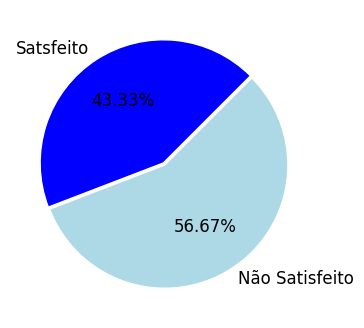

In [15]:
plt.figure( figsize=( 4,4 ) ) # define o tamanho do gráfico
plt.pie( [len( df_eda.loc[ df_eda['Satisfaction'] == 'Satisfied' ] ), # lista de inteiros onde cada item é tam df filtado
          len(df_eda.loc[ df_eda['Satisfaction'] == 'Neutral or Dissatisfaction'])],
          labels = ['Satsfeito','Não Satisfeito'],
          colors = ['#0000FF','#ADD8E6'], 
          explode = [0.01 , 0.01],
          startangle = 45,
          autopct = '%.2f%%',
          wedgeprops = {'linewidth' : 1, 'edgecolor' : 'white'},
          textprops = {'fontsize': 12} );

print( f"Clientes Satisfeitos: {df_eda['Satisfaction'].value_counts()[1]}" )
print( f"Clientes Insatisfeitos: {df_eda['Satisfaction'].value_counts()[0]}" )

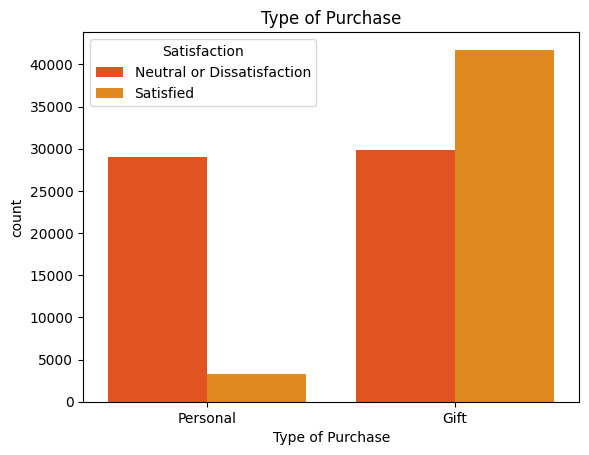

In [16]:
sns.countplot( data = df_eda, x = 'Type of Purchase', hue = 'Satisfaction', palette = layout_palette )
plt.title( 'Type of Purchase' );

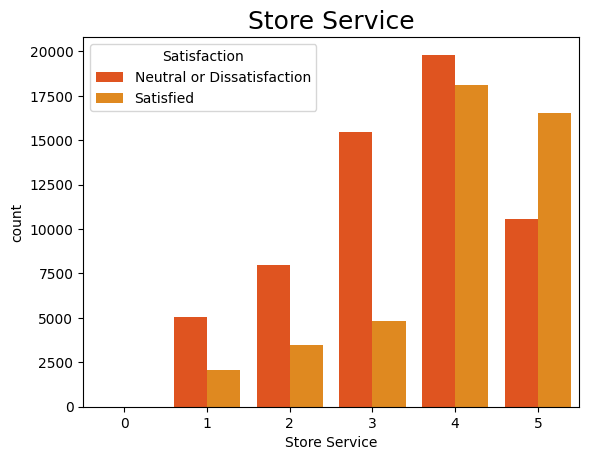

In [17]:
sns.countplot( data = df_eda , x = 'Store Service', hue = 'Satisfaction', palette = layout_palette )
plt.title( 'Store Service', fontsize = 18 );

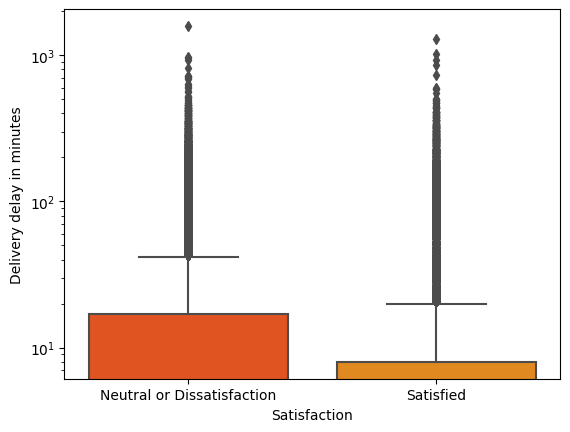

In [18]:
sns.boxplot( data = df, x = 'Satisfaction' , y = 'Delivery delay in minutes', palette = layout_palette )
plt.yscale('log')

# 4 - Data Preparation

In [19]:
df_prep = df.copy()

In [20]:
# função para encodar
def ENCODING( df, is_train = True ):
    
    gender_dict = {'Male':0 , 'Female':1}
    df['Gender'] = df['Gender'].map( gender_dict )
    
    customer_dict = {'disloyal Customer' :0, 'Loyal Customer': 1}
    df['Customer Type'] = df['Customer Type'].map( customer_dict )
    
    gift_dict = {'Gift' : 0, 'Personal' : 1}
    df['Type of Purchase'] = df['Type of Purchase'].map( gift_dict )
    
    size_dict = {'Small': 1, 'Medium': 2, 'Large': 3}
    df['Store size'] = df['Store size'].map( size_dict )
    
    # se is_train for True eu encodo 'Satisfaction'
    if is_train == True:
        satisfaction_dict = {'Neutral or Dissatisfaction' : 0, 'Satisfied': 1}
        df['Satisfaction'] = df['Satisfaction'].map( satisfaction_dict )
        
        
    return df   

In [21]:
# função para reescalar
def RESCALE( df ):
    rs = RobustScaler()
    mms = MinMaxScaler()
    
    df['Carrier delay in minutes'] = rs.fit_transform( df[['Carrier delay in minutes']].values )
    
    df['Delivery delay in minutes'] = rs.fit_transform( df[['Delivery delay in minutes']].values )
    
    df['Store location'] = mms.fit_transform( df[['Store location']].values )
    
    df['Age'] = mms.fit_transform( df[['Age']].values )
    
    return df

In [22]:
# defino a variável resposta
TARGET = 'Satisfaction'

In [23]:
# Dados de treino ( X )
df_prep = ENCODING( df_prep , is_train = True )
df_prep = RESCALE( df_prep )

In [24]:
# Dados de Teste ( Y )
teste = ENCODING( teste, is_train = False )
teste = RESCALE( teste )

# 5 - Feature Selection

In [25]:
SELECTED_FEATURES = ['id',
                     'Gender',
                     'Customer Type',
                     'Age',
                     'Type of Purchase',
                     'Store size',
                     'Store distance',
                     'InStore wifi',
                     'Open/Close time convenient',
                     'Easy of online shopping',
                     'Store location',
                     'Toilet cleaning',
                     'Dressing room',
                     'Waiting room',
                     'Kids entertainment',
                     'Seller service',
                     'Showroom ',
                     'Self-Store',
                     'Purchase service',
                     'Store Service',
                     'Cleanliness',
                     'Carrier delay in minutes',
                     'Delivery delay in minutes']

# 5.1 - Dados de treino e teste

In [26]:
# separando dados de treino em teste
X = df_prep[ SELECTED_FEATURES ]
y = df_prep[ TARGET ]

# 6 - Modelos de Machine Learning

* Lightgbm
* XGBoost
* Random Forest
* Voting Classifier

In [27]:
# splitando os dados
X_train, X_val,y_train,y_val = train_test_split(X, y, test_size = 0.2, stratify = y, shuffle = True, random_state = 42 )
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((83123, 23), (83123,), (20781, 23), (20781,))

In [28]:
# função do confusion matrix
def CM(y, y_pred):
    # define os labels da cn
    labels = ['Não Satisfeito / Neutral', 'Satisfeito']
    
    # confunsiona matrix
    cm = confusion_matrix( y, y_pred )
    
    # display a cm
    disp = ConfusionMatrixDisplay( confusion_matrix = cm , display_labels = labels )
    disp.plot(cmap="Blues", values_format = 'd')
    plt.show()
    print('Score: \n', classification_report( y , y_pred ))

In [29]:
# função de cross validation
def CVS( model, X, y ):
    # crio o número de folds
    number_folds = 5
    
    # crio o Kfold
    Kfold = StratifiedKFold( n_splits = number_folds , shuffle = True , random_state = 42  )
    
    # crio a variavel y_prob
    y_prob = cross_val_predict( model, X , y , cv = Kfold ,  method = 'predict_proba', verbose = False )
    y_prob = y_prob[:,1] # dentro da matrix gerada retorna somente a segunda coluna ( 0 ,1  )
    
    # defino um limite
    threshold = 0.5
    
    # se y_pred for maior que 0.5 retorna 1 do contrário 0
    y_pred = np.where( y_prob >= threshold, 1, 0 )
    
    # plat confusion matrix
    CM( y , y_pred )
    
    # crio a var scores
    scores = cross_validate( model, X, y , cv = Kfold , scoring = ['accuracy','precision','recall','f1_micro','roc_auc'] , return_train_score = True)
    
    # crio um df com os scores
    df = pd.DataFrame.from_dict( scores ).T
    df['value'] = df.mean( axis = 1 )
    df['std'] = df.std( axis = 1 )
    
    # mostra o df
    display( df[['value','std']] )
    
    return y_prob, y_pred

In [30]:
# calcula o balanceamento das classes
weight = round( float( (y.value_counts()[0]) / y.value_counts()[1] ),3 )
weight
# significa que a classe majoritária 0 tem um peso de 1.308 vezes

1.308

In [31]:
results = df_prep['Satisfaction'].copy()

# 7 - Lightgbm

In [32]:
def objective( trial ):
    
    #defino o param_grid
    param_grid = {
        
        'objective': trial.suggest_categorical( 'objective', ['binary'] ),
        'boosting_type': trial.suggest_categorical( 'boosting_type', ['gbdt','dart'] ),
        'num_leaves' : trial.suggest_int( 'num_leaves', 60 , 120 , step = 5 ),
        'max_depth': trial.suggest_int( 'max_depth', 9,21 ),
        'learning_rate' : trial.suggest_float( 'learning_rate', 0.1 , 0.3 ),
        'reg_alpha': trial.suggest_float( 'reg_alpha', 1e-3 , 1e-1, log = True ),
        'reg_lambda': trial.suggest_float( 'reg_lambda', 1e-6 , 1e-4 , log = True ),
        'seed': trial.suggest_categorical('seed', [RANDOM_SEED])
    }
    
    # instancia o modelo
    model = LGBMClassifier( **param_grid, verbose = -1)
    
    # numero de folders
    number_folders = 3
    
    # numero de kfold
    kfold = StratifiedKFold( n_splits = number_folders , shuffle = True )
    
    # y_pred
    y_pred = cross_val_predict( model, X , y, cv = kfold )
    
    return f1_score( y , y_pred )
    

## 7.1 - Estudo com Optuna

In [33]:
study = optuna.create_study( direction = 'maximize' )
optuna.logging.set_verbosity( optuna.logging.WARNING )
study.optimize( objective, n_trials = 120 );

trial = study.best_trial

[I 2023-08-26 11:05:53,425] A new study created in memory with name: no-name-23518555-bbb4-4f5e-b9e1-b9cc054fb456


In [34]:
# resultados
lgbm_best_params = study.best_params
lgbm_best_score = study.best_value
print( 'Best Score: {} \n'.format( lgbm_best_score ) )
print( 'Optimized parameters: \n {}'.format( lgbm_best_params ) )

Best Score: 0.9613487862954646 

Optimized parameters: 
 {'objective': 'binary', 'boosting_type': 'dart', 'num_leaves': 70, 'max_depth': 19, 'learning_rate': 0.2340111319701823, 'reg_alpha': 0.0018509072914351034, 'reg_lambda': 5.529811719867806e-05, 'seed': 42}


In [35]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [36]:
fig = optuna.visualization.plot_slice( study, params = ['learning_rate','max_depth','num_leaves'] )
fig.show()

In [37]:
def lgbm_params_score( param_name , param_range , fixed_params , X_train , y_train , X_val , y_val ):
    
    train_scores = [] # lista vazia
    val_scores   = [] # lista vazia
    
    for param_value in param_range: # percorre em um range que eu defino
        params = fixed_params # fixed_params é o dicionario que retorna do lgbm_best_params
        params[param_name] = param_value 
        
        lgbm = LGBMClassifier(**params, verbose = -1)
        lgbm.fit( X_train , y_train )
        
        train_scores.append( precision_score( y_train, lgbm.predict( X_train ) ) )
        val_scores.append( precision_score( y_val , lgbm.predict( X_val ) ) )
        
    plt.figure( figsize = (8,4) )
    plt.plot( param_range , train_scores , label = 'Train' , color = "#264653" )
    plt.plot( param_range, val_scores, label = 'Val' , color = "#e76f51")
    
    
    plt.title( 'LightGBM' )
    plt.xlabel( param_name )
    plt.ylabel( 'Precision' )
    plt.tight_layout() # ajusta a gráfico na melhor posição
    plt.legend( loc = 'best' );

## 7.2 - Testando com o paramentro learning_rate

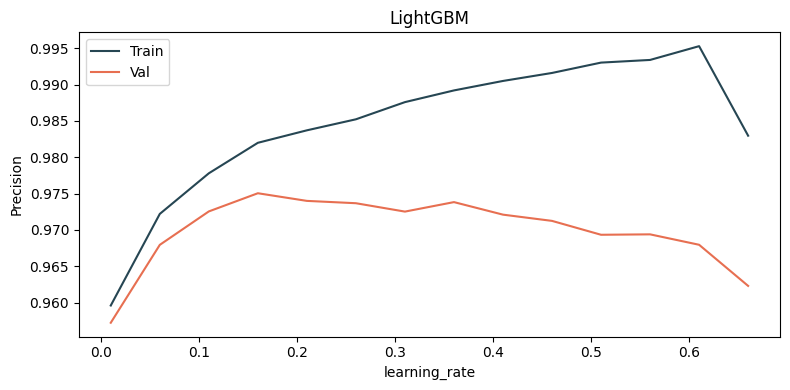

In [38]:
# param_name
param_name = 'learning_rate'
param_range = np.arange( 0.01 , 0.7 , 0.05 )
fixed_params = lgbm_best_params.copy()

#lgbm_params_scores
lgbm_params_score( param_name , param_range , fixed_params , X_train , y_train , X_val , y_val )

In [39]:
# os melhores parametros
lgbm_best_params

{'objective': 'binary',
 'boosting_type': 'dart',
 'num_leaves': 70,
 'max_depth': 19,
 'learning_rate': 0.2340111319701823,
 'reg_alpha': 0.0018509072914351034,
 'reg_lambda': 5.529811719867806e-05,
 'seed': 42}

In [40]:
# best params revised
lgbm_best_params_revised = {'objective': 'binary',
 'boosting_type': 'dart',
 'num_leaves': 65,
 'max_depth': 16,
 'learning_rate': 0.27,
 'reg_alpha': 0.0042,
 'reg_lambda': 1.3e-06,
 'seed': 42}

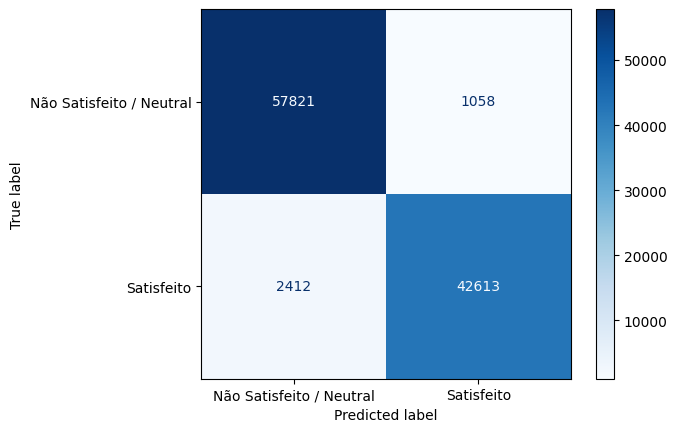

Score: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     58879
           1       0.98      0.95      0.96     45025

    accuracy                           0.97    103904
   macro avg       0.97      0.96      0.97    103904
weighted avg       0.97      0.97      0.97    103904



value       std
fit_time         2.918684  0.766655
score_time       0.249167  0.041015
test_accuracy    0.966604  0.000978
train_accuracy   0.975841  0.000417
test_precision   0.975774  0.001138
train_precision  0.985542  0.000470
test_recall      0.946430  0.001328
train_recall     0.958306  0.000604
test_f1_micro    0.966604  0.000978
train_f1_micro   0.975841  0.000417
test_roc_auc     0.995842  0.000285
train_roc_auc    0.998250  0.000057

In [41]:
# instancia o modelo
lgbm_model = LGBMClassifier(**lgbm_best_params_revised, verbose = -1)

# treina o modelo
lgbm_model.fit( X , y )

# pega a matrix de confusão
lgbm_prob, lgbm_pred = CVS( lgbm_model, X , y )

## 7.3 - Testando com o parametro "max_depth"

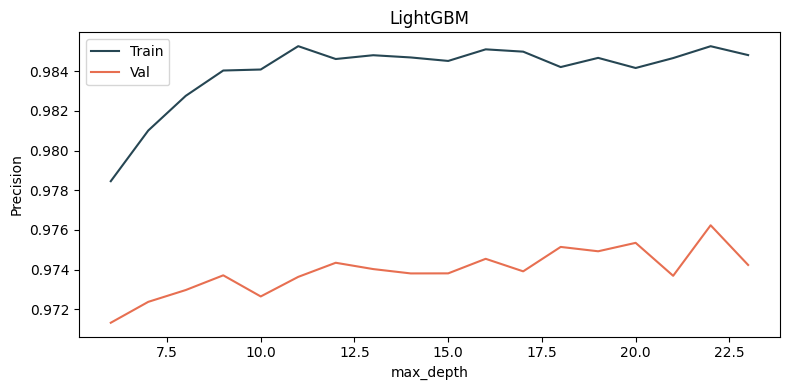

In [42]:
# definindo os parametros
param_name = 'max_depth'
param_range = np.arange( 6 , 24 ,1 )
fixed_params = lgbm_best_params.copy()

# lgbm_params_score
lgbm_params_score( param_name , param_range , fixed_params , X_train , y_train , X_val , y_val )

In [43]:
lgbm_best_params_revised = {'objective': 'binary',
 'boosting_type': 'dart',
 'num_leaves': 65,
 'max_depth': 16,
 'learning_rate': 0.27,
 'reg_alpha': 0.0042,
 'reg_lambda': 1.3e-06,
 'seed': 42}

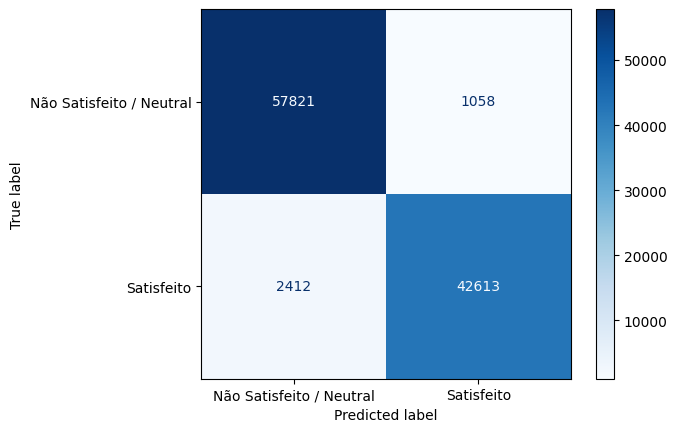

Score: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     58879
           1       0.98      0.95      0.96     45025

    accuracy                           0.97    103904
   macro avg       0.97      0.96      0.97    103904
weighted avg       0.97      0.97      0.97    103904



value       std
fit_time         2.886848  0.261180
score_time       0.251827  0.033942
test_accuracy    0.966604  0.000978
train_accuracy   0.975841  0.000417
test_precision   0.975774  0.001138
train_precision  0.985542  0.000470
test_recall      0.946430  0.001328
train_recall     0.958306  0.000604
test_f1_micro    0.966604  0.000978
train_f1_micro   0.975841  0.000417
test_roc_auc     0.995842  0.000285
train_roc_auc    0.998250  0.000057

In [44]:
# lgbm
lgbm_model = LGBMClassifier(**lgbm_best_params_revised, verbose = -1)
lgbm_model.fit( X, y )
lgbm_prob , lgbm_pred = CVS( lgbm_model, X, y )

# 8.0 - XGBOOST

In [45]:
def objective( trial ):
    
    param_grid = {
        
        'objective': trial.suggest_categorical( 'objective', ['binary:logistic'] ),
        'booster': trial.suggest_categorical( 'booster', ['dart','gbtree'] ) ,
        'eval_metric': trial.suggest_categorical( 'eval_metric', ['auc'] ) , 
        'max_depth' : trial.suggest_int( 'max_depth', 6 , 12 ) , 
        'learning_rate' : trial.suggest_float( 'learning_rate', 0.1 , 0.25 ),
        'n_estimators' : trial.suggest_int( 'n_estimators', 60 , 240, step = 20 ),
        'alpha' : trial.suggest_float( 'alpha', 1e-4 , 1e-1 , log = True),
        'lambda': trial.suggest_float( 'lambda', 1e-4 , 1e-1 , log = True ),
        'seed': trial.suggest_categorical( 'seed', [RANDOM_SEED] )
        
    }
    
    model = XGBClassifier(**param_grid)
    number_folds = 3
    KFold = StratifiedKFold( n_splits = number_folds, shuffle = False )
    y_pred = cross_val_predict( model, X , y , cv = KFold )
    
    return f1_score( y , y_pred )

In [46]:
# estudos optuna para Xgboost
study = optuna.create_study( direction = 'maximize' )
optuna.logging.set_verbosity( optuna.logging.WARNING )
study.optimize( objective , n_trials = 5 )

trial = study.best_trial

In [47]:
# resultados
xgb_best_params = study.best_params
xgb_best_score = study.best_value
print( f'Best score: { xgb_best_score }\n' )
print( f'Optimized parameters: {xgb_best_params}\n' )

Best score: 0.9588008237584542

Optimized parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'eval_metric': 'auc', 'max_depth': 9, 'learning_rate': 0.21340450825934798, 'n_estimators': 60, 'alpha': 0.0007121598013010865, 'lambda': 0.0037586809301224074, 'seed': 42}



In [48]:
# best params revised
xgb_best_params_revised = {'objective': 'binary:logistic',
 'booster': 'gbtree',
 'eval_metric': 'auc',
 'max_depth': 11,
 'learning_rate': 0.12,
 'n_estimators': 180,
 'alpha': 0.0144,
 'lambda': 0.0022,
 'seed': 42}

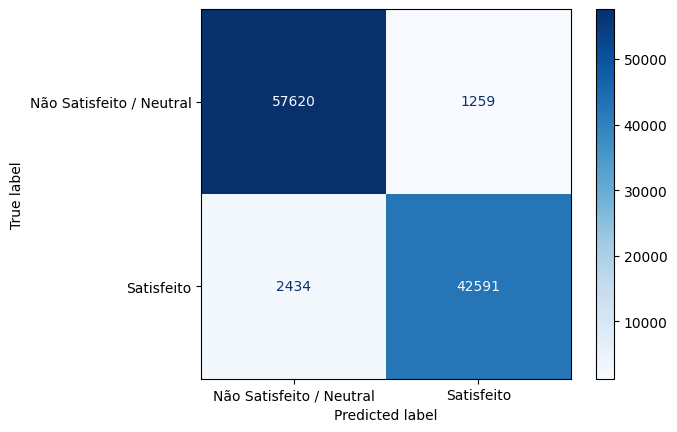

Score: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     58879
           1       0.97      0.95      0.96     45025

    accuracy                           0.96    103904
   macro avg       0.97      0.96      0.96    103904
weighted avg       0.96      0.96      0.96    103904



value           std
fit_time         25.625395  1.034309e+00
score_time        0.257212  1.679869e-02
test_accuracy     0.964458  9.673832e-04
train_accuracy    0.999808  8.088155e-05
test_precision    0.971290  1.107687e-03
train_precision   0.999889  3.043367e-05
test_recall       0.945941  2.167484e-03
train_recall      0.999667  1.580261e-04
test_f1_micro     0.964458  9.673832e-04
train_f1_micro    0.999808  8.088155e-05
test_roc_auc      0.995432  3.061597e-04
train_roc_auc     1.000000  7.425065e-08

In [49]:
# xgb_model
xgb_model = XGBClassifier(**xgb_best_params_revised)
xgb_model.fit( X , y )
xgb_prob, xgb_pred = CVS( xgb_model, X , y )

# 9.0 - Random Forest 

In [50]:
def objective( trial ):
    
    param_grid = {
        
        'criterion': trial.suggest_categorical( 'criterion', ['gini','entropy'] ),
        'n_estimators': trial.suggest_int( 'n_estimators', 60 , 180 , step = 20 ) , 
        'max_depth': trial.suggest_int( 'max_depth', 8 , 18 ),
        'min_samples_split': trial.suggest_int( 'min_samples_split', 3 , 10 ),
        'min_samples_leaf': trial.suggest_int( 'min_samples_leaf', 1 , 3 ),
        'random_state': RANDOM_SEED
        }
    
    model = RandomForestClassifier(**param_grid)
    
    number_folds = 3
    
    KFold = StratifiedKFold( n_splits = number_folds, shuffle = False )
    
    y_pred = cross_val_predict( model, X , y , cv = KFold  )
    
    return f1_score( y , y_pred )

In [51]:
study = optuna.create_study( direction = 'maximize' )
optuna.logging.set_verbosity( optuna.logging.WARNING )
study.optimize( objective, n_trials = 4 );

trial = study.best_trial


In [52]:
# result
rf_best_params = study.best_params
rf_best_score = study.best_value
print( f'Best Score: {rf_best_score}\n' )
print( f'Best paramns: {rf_best_params}\n' )

Best Score: 0.948879409574108

Best paramns: {'criterion': 'gini', 'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 2}



In [53]:
# best params revised
rf_best_params_revised = {'criterion': 'entropy',
 'n_estimators': 100,
 'max_depth': 17,
 'min_samples_split': 5,
 'min_samples_leaf': 1}

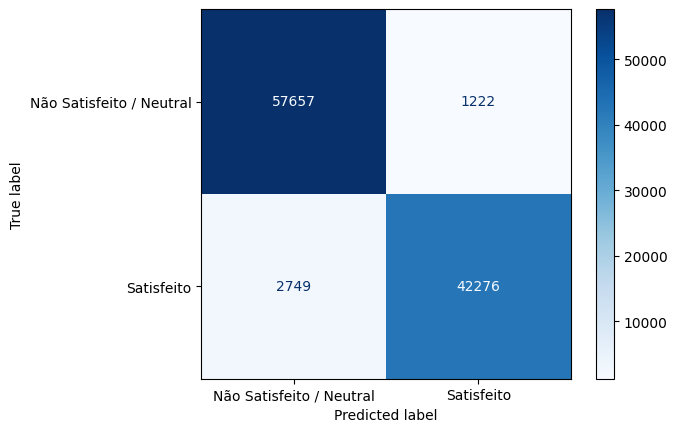

Score: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.97     58879
           1       0.97      0.94      0.96     45025

    accuracy                           0.96    103904
   macro avg       0.96      0.96      0.96    103904
weighted avg       0.96      0.96      0.96    103904



value       std
fit_time         16.633642  0.808123
score_time        0.710170  0.126561
test_accuracy     0.961965  0.001194
train_accuracy    0.982852  0.000205
test_precision    0.972463  0.001125
train_precision   0.990863  0.000430
test_recall       0.938812  0.002585
train_recall      0.969367  0.000305
test_f1_micro     0.961965  0.001194
train_f1_micro    0.982852  0.000205
test_roc_auc      0.993906  0.000419
train_roc_auc     0.999204  0.000029

In [54]:
rf_model = RandomForestClassifier(**rf_best_params_revised)
rf_model.fit( X , y )
rf_prob, rf_pred = CVS( rf_model, X, y )

# 10.0 - Voting Classifier

In [55]:
voting = VotingClassifier( estimators = [ ('Lightgbm', lgbm_model ),
                                          ('XGBoost', xgb_model ) ,
                                          ('Random Forest', rf_model)],
                                          voting = 'soft')


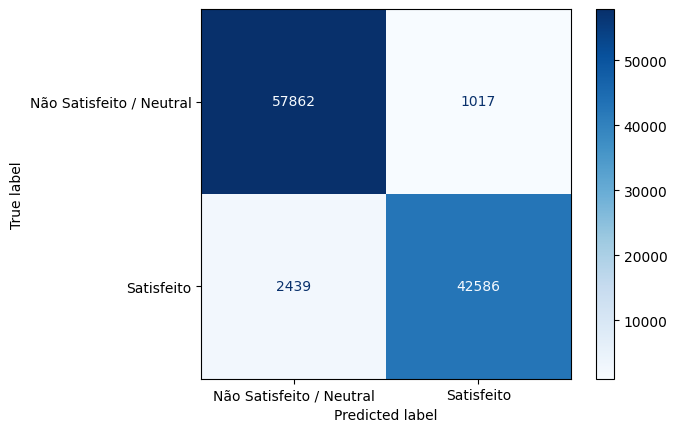

Score: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     58879
           1       0.98      0.95      0.96     45025

    accuracy                           0.97    103904
   macro avg       0.97      0.96      0.97    103904
weighted avg       0.97      0.97      0.97    103904



value       std
fit_time         44.284468  2.642407
score_time        0.982148  0.093593
test_accuracy     0.966671  0.000771
train_accuracy    0.993044  0.000497
test_precision    0.976718  0.001029
train_precision   0.997066  0.000351
test_recall       0.945630  0.001952
train_recall      0.986852  0.001002
test_f1_micro     0.966671  0.000771
train_f1_micro    0.993044  0.000497
test_roc_auc      0.995553  0.000315
train_roc_auc     0.999903  0.000009

In [56]:
# treinar
voting.fit( X, y )
voting_prob, voting_pred = CVS( voting, X, y )

# 11.0 - Feature Importance

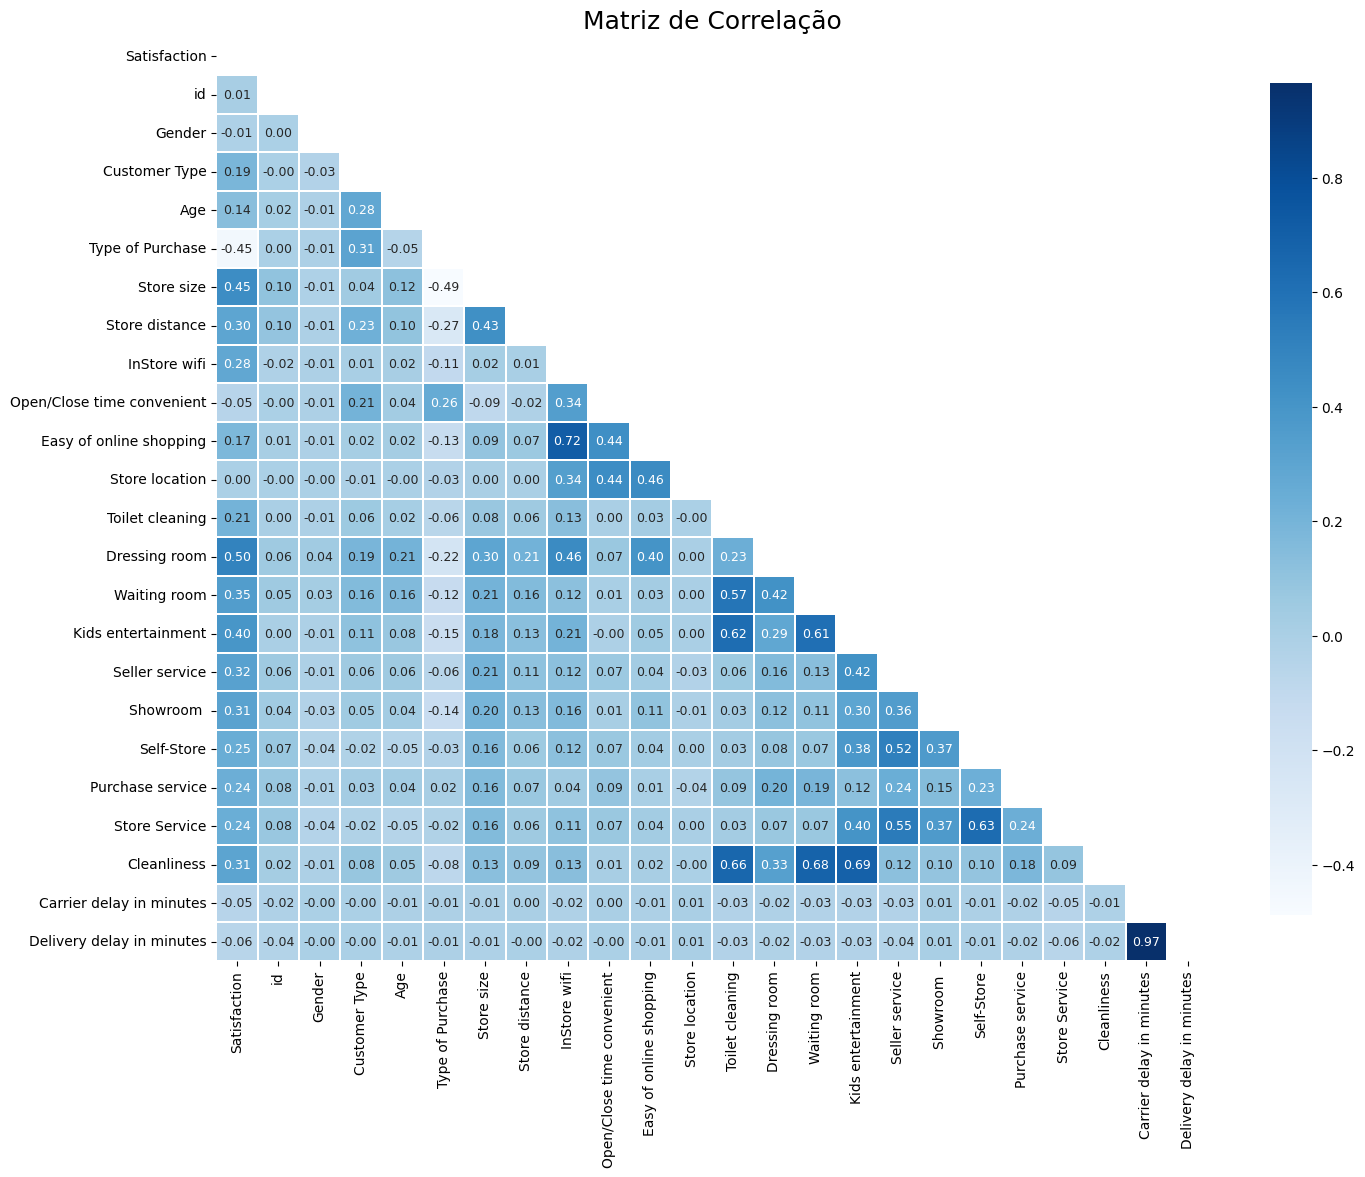

In [57]:
aux = pd.concat([y,X], axis=1)

mask = np.zeros_like(aux.corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))

plt.title('Matriz de Correlação',fontsize=18)
sns.heatmap(aux.corr(),linewidths=0.25,fmt=".2f", cmap="Blues", linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});

In [58]:
# treina o modelo vencedor
lgbm_model.fit( X , y )
explainer = shap.Explainer( lgbm_model, X )
shap_values = explainer(X)

100%|===================| 103803/103904 [13:37<00:00]        

In [59]:
# inicializa o shap
shap.initjs()

In [60]:
idx = 197

In [61]:
df.iloc[ idx, : ]

id                                                 56446
Gender                                            Female
Customer Type                             Loyal Customer
Age                                                   52
Type of Purchase                                Personal
Store size                                        Medium
Store distance                                       719
InStore wifi                                           1
Open/Close time convenient                             5
Easy of online shopping                                2
Store location                                         2
Toilet cleaning                                        3
Dressing room                                          5
Waiting room                                           5
Kids entertainment                                     3
Seller service                                         3
Showroom                                               2
Self-Store                     

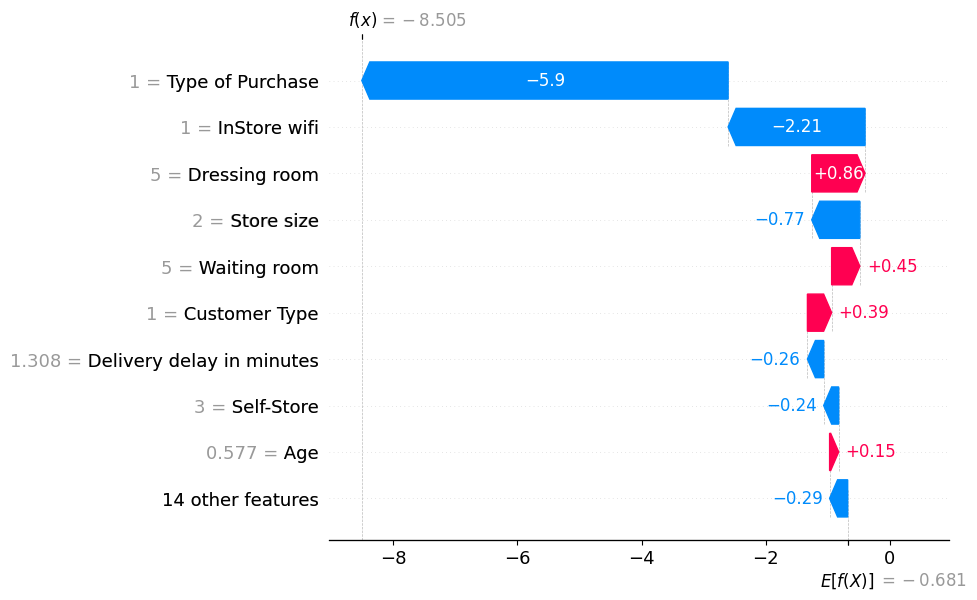

In [62]:
# explicabilidade da linha
shap.plots.waterfall( shap_values[ idx, : ] )

C:\Users\oscar\anaconda3\envs\hackdays_5\lib\site-packages\shap\plots\_beeswarm.py:375: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



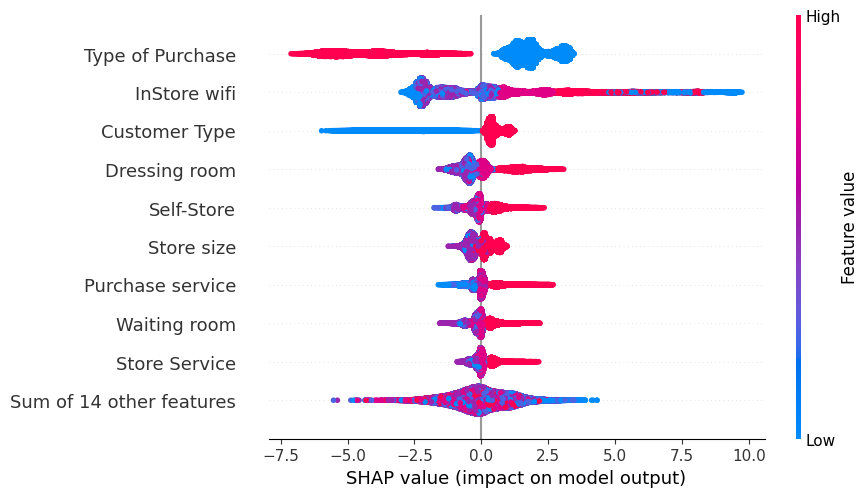

In [63]:
# explicabilidade geral, positivo / negativo
shap.plots.beeswarm( shap_values )

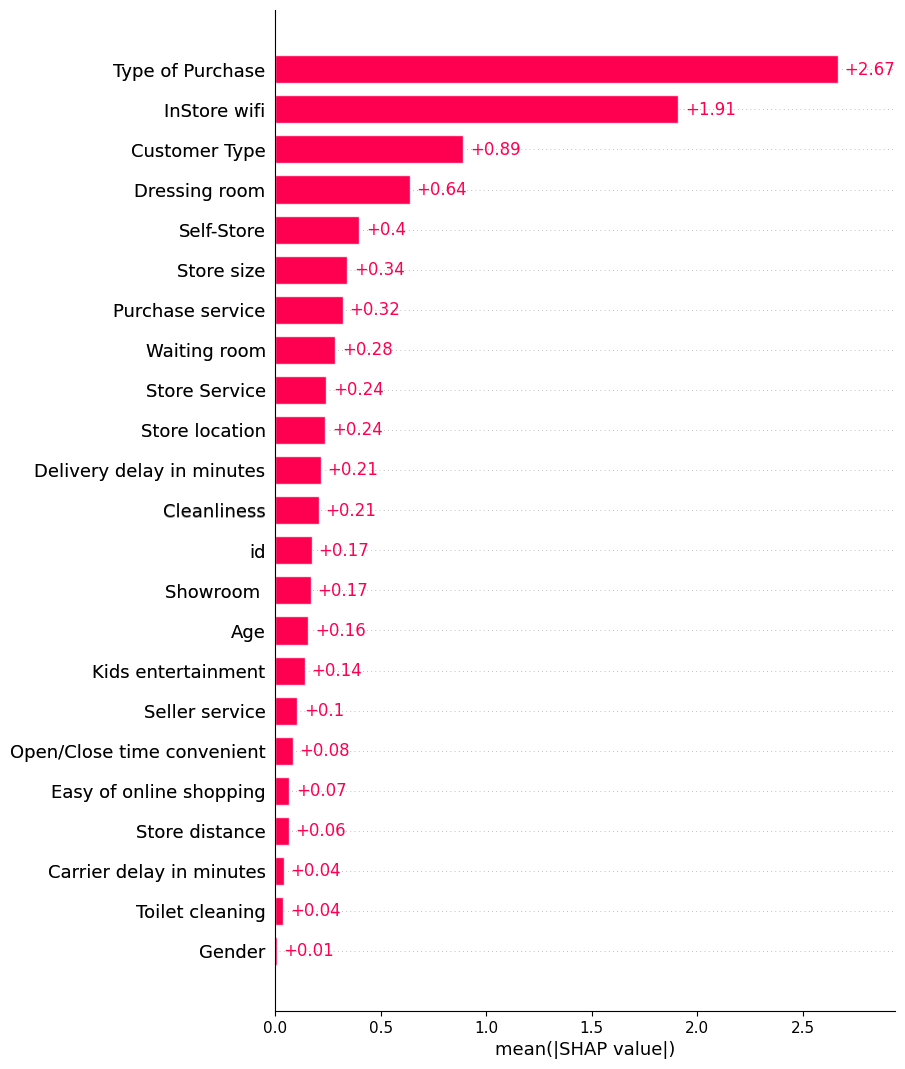

In [64]:
# explicabilidade geral média
shap.plots.bar( shap_values, max_display = 25 )